In [1]:
import numpy as np
import chainer
from chainer import Variable, Chain
import chainer.functions as F, chainer.links as L

import matplotlib
import matplotlib.pyplot as plt

# Defining some useful functions

First, we define a few functions that will help us visualize and evaluate our models. If you do not know much of python and numpy, you do not need to try to understand them. Just look at the description to understand what they do.

`display_car_cat_images` is a convenience function for displaying a list of images in a grid. The first parameter is a list of images (represented as numpy arrays). If we give the optional `labels` argument, `labels` must be a list of the same size as the list of images. The list contains a zero if the corresponding image should be labeled as a *car*, or a one if it should be labeled as a *cat*. If the labels are given, the "CAT" or "CAR" will be printed on top of the corresponding image.

Instead of giving the labels separately, images_with_class can be a list of tuples, each tuple containing an image and a label.

In [2]:
def display_car_cat_images(images_with_class, labels = None, prediction_beliefs = None, nb_images_per_row=4):
    nb_images = len(images_with_class)
    if isinstance(images_with_class[0], tuple):
        #Case when we have classes packed in
        images = [image for image, is_cat in images_with_class]
        if labels == "from_data":
            labels = [is_cat for image, is_cat in images_with_class]
    else:
        images = images_with_class
        
        
    # Note that we expect the channel dimension to be the first dimension here. This is because
    # it is the ordering used by chainer's convolutional layers.
    nb_channels, xdim, ydim = images[0].shape
    
    remainders = nb_images % nb_images_per_row
    nb_rows = nb_images// nb_images_per_row + (1 if remainders >0 else 0)
    
    
    result = np.zeros((nb_rows*xdim, nb_images_per_row*ydim, 3))
    
    labels_pos = []
    for num_image, image in enumerate(images):
        num_row = num_image // nb_images_per_row
        num_column = num_image % nb_images_per_row
        x1 = num_row*xdim
        x2 = (num_row+1)*xdim
        y1 = num_column*ydim
        y2 = (num_column+1)*ydim
        labels_pos.append((y1+3,x1+30))
        result[x1:x2, y1:y2, :] = np.moveaxis(image, 0, 2)
    
    fig = plt.figure(figsize=(15,15))
    im = plt.imshow(result)
    if labels is not None:
        for num_image, (pos, label) in enumerate(zip(labels_pos, labels)):
            label = int(label)
            label_text =  ["CAR", "CAT"][label]
            if prediction_beliefs is not None:
                label_text += " %i%%"%(prediction_beliefs[num_image]*100)
            im.axes.text(pos[0], pos[1], label_text, fontsize=20, weight="bold", color="red")
    

`display_monochrome_image` is a convenience function for displaying images with only one channel (ie. monochrome images). It is useful for visualizing each individual channels of a 3D array.

In [3]:
def display_monochrome_image(img, scale_intensity=True, color="grey"):
    if isinstance(img, Variable):
        img = img.array
    if scale_intensity:
        min = np.min(img)
        max = np.max(img)
        img = (img-min) / (max-min)
    
    if color == "red":
        expanded_image = np.zeros(img.shape + (3,))
        expanded_image[:,:,0] = img
    elif color == "green":
        expanded_image = np.zeros(img.shape + (3,))
        expanded_image[:,:,1] = img
    elif color == "blue":
        expanded_image = np.zeros(img.shape + (3,))
        expanded_image[:,:,2] = img
    else:
        expanded_image = np.broadcast_to(img[...,None], img.shape + (3,))
        
    plt.imshow(expanded_image)

In [4]:
def display_all_channels(img_3D, scale_intensity=True):
    if isinstance(img_3D, Variable):
        img_3D = img_3D.array
    if scale_intensity:
        min = np.min(img_3D)
        max = np.max(img_3D)
        img_3D = (img_3D-min) / (max-min)
    expanded_image = np.broadcast_to(img_3D[:,None,:,:], (img_3D.shape[0],3, img_3D.shape[1], img_3D.shape[2]))
    display_car_cat_images(expanded_image)

`evaluate_accuracy_of_model` will check how many images in a dataset are correctly predicted by our model.

In [5]:
def evaluate_accuracy_of_model(model, dataset):
    right = 0
    wrong = 0
    for i in range(len(dataset)):
        if np.round(model(dataset[i][0][None,...]).array[0,0]) == dataset[i][1]:
            right += 1
        else:
            wrong += 1
    print(f"Accurracy is {right}/{right+wrong} = {100*right/(right+wrong)}%")

`display_model_predictions` will compute the predictions of the model for the images in `data`. It then display the images and their predictions.

In [6]:
def display_model_predictions(model, data, with_beliefs=False):
    labels_predictions = []
    labels_beliefs = []
    for i in range(len(data)):
        belief = model(data[i][0][None,...]).array[0,0]
        labels_beliefs.append(belief if belief > 0.5 else (1-belief))
        labels_predictions.append(np.round(belief))
    display_car_cat_images(data, labels=labels_predictions, 
                           prediction_beliefs = labels_beliefs if with_beliefs else None
                          )

# Getting some images for training and testing

We are going to use the CIFAR10 dataset. CIFAR10 contains 60 000 tiny images (32pixels x 32pixels) labeled according to 10 different classes (airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks). The images are divided in a set of 50 000 images for training, and a set of 10 000 images for testing.

To keep things simple, we are only going to do binary classification here. Therefore, we are going to only keep images of **car** and **cat**. We will therefore have 10 000 images for training and 2 000 for testing.

`chainer` has a function for automatically downloading and loading the CIFAR10 dataset from internet. This function is called `chainer.datasets.get_cifar10()`. The first time you call it, your computer needs to be connected to internet. And you might need to wait a bit for the data to be downloaded. The CIFAR10 data will then be saved on your computer. Therefore, you do not need an access to internet the if you call this function a second time.

In [7]:
cifar10_training_set, cifar10_test_set = chainer.datasets.get_cifar10()

We are only going to use the images labeled as **car** or **cat**. In the original CIFAR10 dataset, the **car** corresponds to label `1` and **cat** corresponds to label `3`. We are going to select the images containing a **car** or a **cat**, and assign a new label `0` for images of **car**, and a new label `1` for images of **cat**.

In [8]:
car_cat_training_set = [(img, 0 if cls == 1 else 1) for img, cls in cifar10_training_set if cls==3 or cls ==1]
car_cat_test_set = [(img, 0 if cls == 1 else 1) for img, cls in cifar10_test_set if cls==3 or cls ==1]

# Looking at our data
Let us have a look at our data.

`car_cat_training_set` is a list that contains 10 000 images and their labels. 

In [9]:
print("There are", len(car_cat_training_set), "training examples")

There are 10000 training examples


Similarly, `car_cat_test_set` is a list that contains 2 000 **other** images and their labels. 

In [11]:
print("There are", len(car_cat_test_set), "training examples")

There are 2000 training examples


We can, for example, look at the third image of the training set, and its label:

In [12]:
third_image, third_label = car_cat_training_set[2]

print("The label of the third image of the training set is", third_label)

The label of the third image of the training set is 1


The label of the third image is `1`, which corresponds to a **cat**. What does the image looks like:

In [13]:
print(third_image)

[[[0.4901961  0.43137258 0.40000004 ... 0.79215693 0.7843138  0.79215693]
  [0.5568628  0.57254905 0.6901961  ... 0.76470596 0.77647066 0.8000001 ]
  [0.7058824  0.56078434 0.6117647  ... 0.4784314  0.54509807 0.61960787]
  ...
  [0.40784317 0.39607847 0.39607847 ... 0.49411768 0.49411768 0.4901961 ]
  [0.40784317 0.41176474 0.427451   ... 0.5411765  0.5372549  0.5372549 ]
  [0.41176474 0.42352945 0.45098042 ... 0.56078434 0.56078434 0.5647059 ]]

 [[0.4901961  0.39607847 0.3529412  ... 0.8117648  0.80392164 0.81568635]
  [0.57254905 0.5647059  0.6745098  ... 0.78823537 0.80392164 0.82745105]
  [0.7254902  0.57254905 0.6156863  ... 0.43529415 0.5019608  0.5764706 ]
  ...
  [0.32156864 0.3137255  0.31764707 ... 0.4039216  0.4039216  0.39607847]
  [0.31764707 0.32941177 0.34509805 ... 0.4431373  0.4431373  0.43921572]
  [0.3254902  0.34117648 0.36862746 ... 0.45882356 0.454902   0.454902  ]]

 [[0.454902   0.35686275 0.3254902  ... 0.83921576 0.8313726  0.83921576]
  [0.5568628  0.545098

As expected, the third image is just an array of number. Let us check its dimensions:

In [14]:
print("Here is the shape of third_image:", third_image.shape)

Here is the shape of third_image: (3, 32, 32)


The images of CIFAR10 have a resolution of 32x32 pixels. So we are not surprised to see the two `32` in the shape. They are images in color, so we are not surprised to see a `3` in the shape as well (corresponding to the 3 RGB channels). It is however unusual to have the number of channels corresponding to the first dimension of the 3D array. Outside of the realm of Deep Learning, it is indeed more commmon to have the channel dimension be the last one. But many Neural Network libraries (including `chainer`) expect the channel dimension to be the first for computational efficiency reasons. We can anyway always move the channel dimension with the `np.moveaxis` command.

We can look at the red channel of the third image, for example:

In [15]:
print(third_image[0])

[[0.4901961  0.43137258 0.40000004 ... 0.79215693 0.7843138  0.79215693]
 [0.5568628  0.57254905 0.6901961  ... 0.76470596 0.77647066 0.8000001 ]
 [0.7058824  0.56078434 0.6117647  ... 0.4784314  0.54509807 0.61960787]
 ...
 [0.40784317 0.39607847 0.39607847 ... 0.49411768 0.49411768 0.4901961 ]
 [0.40784317 0.41176474 0.427451   ... 0.5411765  0.5372549  0.5372549 ]
 [0.41176474 0.42352945 0.45098042 ... 0.56078434 0.56078434 0.5647059 ]]


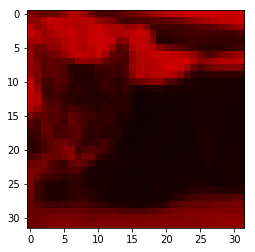

In [16]:
display_monochrome_image(third_image[0], color="red", scale_intensity=False)

We can similarly visualize the green and blue channels:

In [17]:
print(third_image[1])

[[0.4901961  0.39607847 0.3529412  ... 0.8117648  0.80392164 0.81568635]
 [0.57254905 0.5647059  0.6745098  ... 0.78823537 0.80392164 0.82745105]
 [0.7254902  0.57254905 0.6156863  ... 0.43529415 0.5019608  0.5764706 ]
 ...
 [0.32156864 0.3137255  0.31764707 ... 0.4039216  0.4039216  0.39607847]
 [0.31764707 0.32941177 0.34509805 ... 0.4431373  0.4431373  0.43921572]
 [0.3254902  0.34117648 0.36862746 ... 0.45882356 0.454902   0.454902  ]]


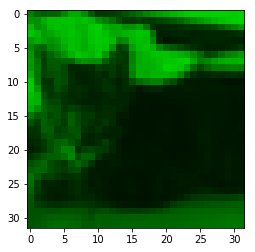

In [18]:
display_monochrome_image(third_image[1], color="green", scale_intensity=False)

In [19]:
print(third_image[2])

[[0.454902   0.35686275 0.3254902  ... 0.83921576 0.8313726  0.83921576]
 [0.5568628  0.54509807 0.6666667  ... 0.80392164 0.8196079  0.8431373 ]
 [0.7176471  0.57254905 0.6156863  ... 0.4431373  0.5137255  0.5882353 ]
 ...
 [0.16078432 0.15294118 0.14901961 ... 0.2627451  0.27058825 0.26666668]
 [0.15686275 0.16078432 0.16862746 ... 0.30588236 0.3137255  0.31764707]
 [0.16470589 0.1764706  0.19607845 ... 0.32156864 0.32941177 0.3372549 ]]


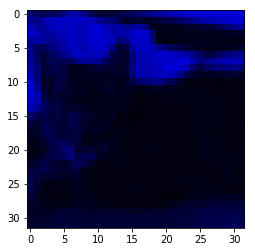

In [20]:
display_monochrome_image(third_image[2], color="blue", scale_intensity=False)

We can use the matplotlib `imshow` function for displaying the color image. ( but we first need to move the channel dimension with `np.moveaxis`).

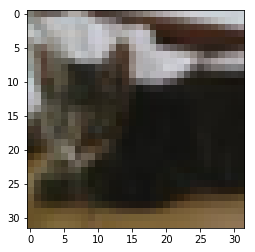

In [21]:
plt.imshow(np.moveaxis(third_image,0,2))

Let us now use the `display_car_cat_images` to have a look at some more images of the training set:

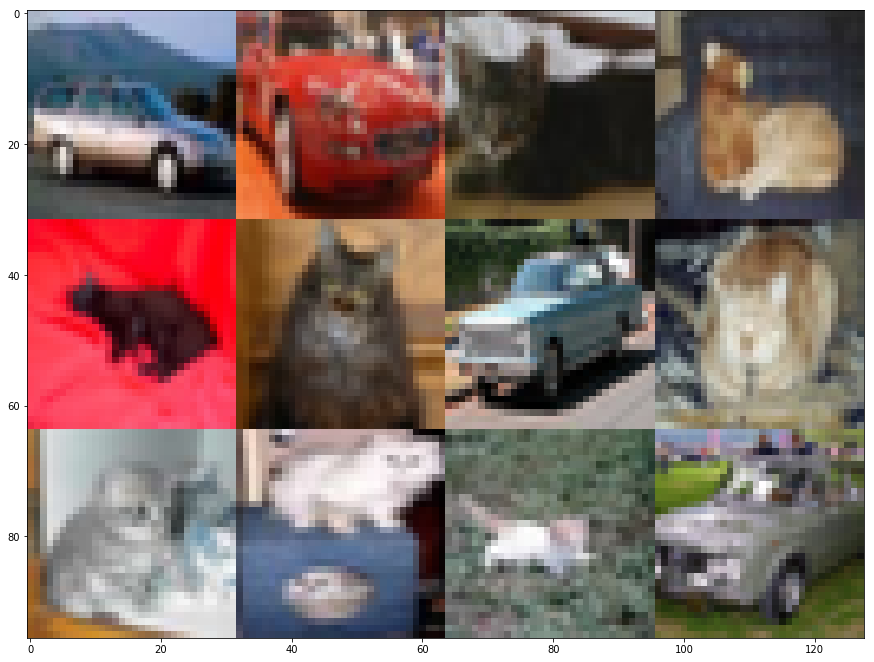

In [22]:
display_car_cat_images(car_cat_training_set[:12])

Let us display the same images with their official labels:

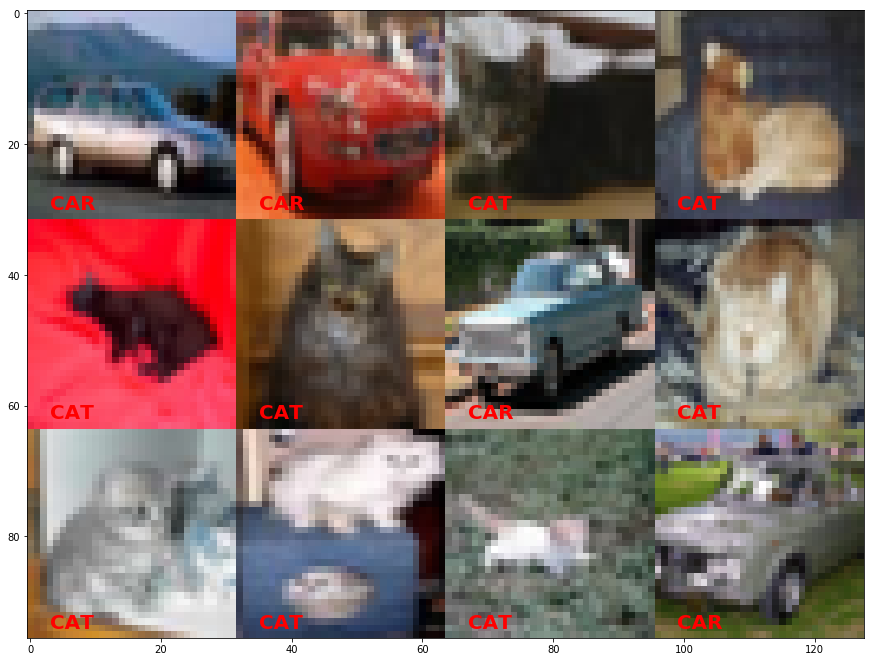

In [23]:
display_car_cat_images(car_cat_training_set[:12],labels="from_data")

We can do the same for the test data. Let us look at the first images of the test data:

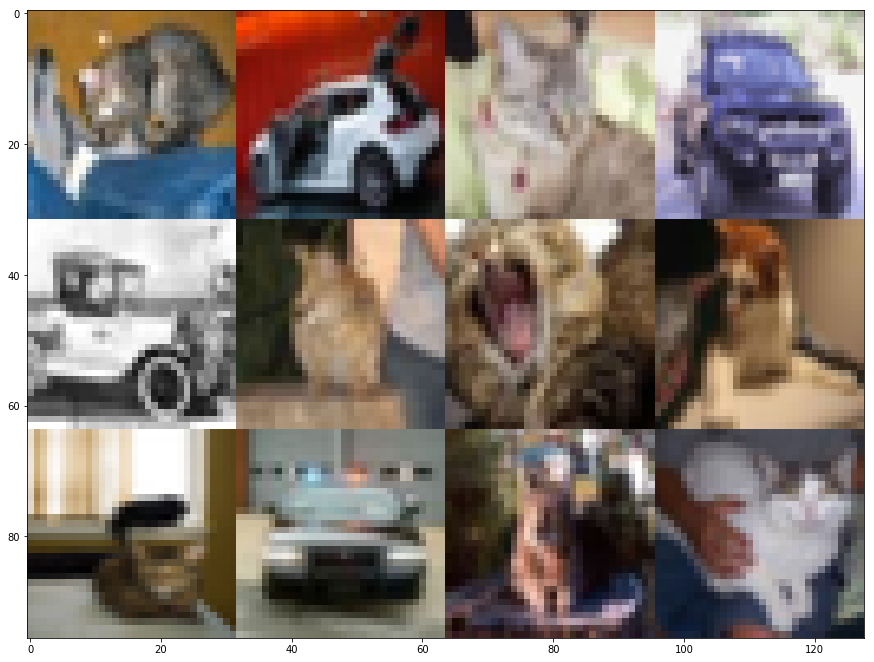

In [24]:
display_car_cat_images(car_cat_test_set[:12])

As you can see, the images are different. Our goal is going to be to train a CAR/CAT Image Recognition model on the 10 000 training images. Then check that it works well on the 2 000 test images

# New Chainer Components

We already described in a previous Notebook the link `L.Linear` and the functions `F.sigmoid` and `F.sigmoid_cross_entropy`. We will need one additional link: `L.Convolution2D`. And one additional function: `F.max_pooling_2d`. (Remember that, in `chainer` terminology, a `link` is a function that include some trainable parameters).

## L.Convolution2D

As the name inply, the `Convolution2D` link represents a convolution layer. We create a convolution layer by calling `L.Convolution2D(nb_channels_in, nb_channels_out, ksize=kernel_size, pad=padding_if_any)`.

`nb_channels_in` represents the number of channels in the input array. `nb_channels_out` represents the number of channels in the output array. `kernel_size` is the size of the kernel. The `pad` value represents the number of zero columns/rows we will add around the input. Remember that we saw in class that if we do not add padding zeros, the size of the output will be smaller than the size of the input.

This link will represent a volume convolution with a learnable 4D kernel of dimensions `ksize x ksize x nb_channels_in x nb_channels_out`.

Let us try to create a convolution layer that takes an array with 3 channels as input (eg. an image) and return an array with one channel.

In [25]:
my_convolution = L.Convolution2D(3, 1, ksize=3)

We can check the values of the learnable kernel (which is randomly initialized for now):

In [26]:
print(my_convolution.W)

variable W([[[[ 0.05747231 -0.3323162  -0.12864041]
              [ 0.24481049  0.01405234  0.06403702]
              [-0.17174521  0.02313347  0.14840496]]

             [[-0.15024266  0.17601229  0.08472057]
              [-0.1498273  -0.03993116 -0.13152045]
              [ 0.18836981 -0.03224199 -0.1522765 ]]

             [[-0.1309054   0.04589839 -0.11262056]
              [ 0.06704443 -0.21025537  0.20749658]
              [-0.1795126   0.22334948 -0.23501499]]]])


The kernel is a 4D array as expected, but note that its dimensions are actually `nb_channels_out x nb_channels_in x ksize x ksize` and not `ksize x ksize x nb_channels_in x nb_channels_out` as we were writing in class. This is however just an implementation detail related to how chainer compute convolutions.

In [27]:
print("Dimensions of the learnable kernel:", my_convolution.W.shape)

Dimensions of the learnable kernel: (1, 3, 3, 3)


Like all chainer links and functions, Convolution2D expect to receive a batch of input, and not just one input. In practice, it means that the input should be a 4-dimensional array of dimensions `nb_inputs x nb_channels x height x width`

For example, let us say we create a random input of 5 images of dimensions 10x20:


In [28]:
batched_input = np.random.randn(5, 3, 10, 20).astype(np.float32)

print("Dimensions of input:", batched_input.shape)

Dimensions of input: (5, 3, 10, 20)


Next, we can apply our convolution to it:

In [29]:
batched_output = my_convolution(batched_input)

print("Dimensions of output:", batched_output.shape)

Dimensions of output: (5, 1, 8, 18)


As expected, we have 5 outputs (the first dimension), corresponding to the 5 inputs. Note that the height and width of the output have been decreased by 2. To prevent this, we can specify that our convolution uses padding:

In [30]:
my_convolution_with_padding = L.Convolution2D(3, 1, ksize=3, pad=1)

batched_output = my_convolution_with_padding(batched_input)

print("Dimensions of output:", batched_output.shape)

Dimensions of output: (5, 1, 10, 20)


Let us try to apply this convolution to the third image we extracted above. This third immage has dimensions 3x32x32:

In [32]:
print("dimensions of third image:", third_image.shape)

dimensions of third image: (3, 32, 32)


Because `Convolution2D` expect an input with 4 dimensions (the first dimension corresponding to the number of inputs, we actually need to put `third_image` in a `1x3x32x32` array. One "magical way" to do that is to add `[np.newaxis,...]` to the image:

In [33]:
batch_third_image = third_image[np.newaxis,...]

print("dimensions of batch_third_image:", batch_third_image.shape)

dimensions of batch_third_image: (1, 3, 32, 32)


If we apply `my_convolution` to `batch_third_image`, we get an output with one channel and slightly reduced heigth and width:

In [34]:
convolved_third_image = my_convolution(batch_third_image)

print("dimensions of convolved_third_image:", convolved_third_image.shape)

dimensions of convolved_third_image: (1, 1, 30, 30)


By using padding, the height and width can remain the same:

In [35]:
convolved_third_image = my_convolution_with_padding(batch_third_image)

print("dimensions of convolved_third_image:", convolved_third_image.shape)

dimensions of convolved_third_image: (1, 1, 32, 32)


In this case, the output has just one channel. So we can visualize it as a greyscale image. Let us get the corresponding 32x32 array with `convolved_third_image[0,0]` (this means we take the first channel of the first input in the batch.

In [36]:
first_channel_of_convolved_third_image = convolved_third_image[0,0]

print("dimensions of first_channel_of_convolved_third_image:", first_channel_of_convolved_third_image.shape)

dimensions of first_channel_of_convolved_third_image: (32, 32)


In [37]:
print (first_channel_of_convolved_third_image)

variable([[0.14604482 0.28284442 0.25545496 ... 0.33402836 0.33911815
           0.49109083]
          [0.4989706  0.5088455  0.48920888 ... 0.81674063 0.84141123
           0.9113834 ]
          [0.61088324 0.7008401  0.7423993  ... 0.67799944 0.7206322
           0.7497812 ]
          ...
          [0.4703903  0.36354122 0.3604583  ... 0.48588887 0.49311236
           0.39382455]
          [0.47609055 0.41636354 0.42997143 ... 0.5340886  0.53387654
           0.43222693]
          [0.3401392  0.2903588  0.30901304 ... 0.39479622 0.393861
           0.34915844]])


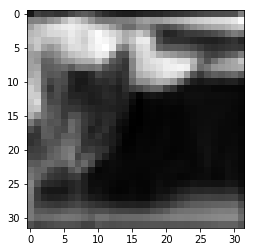

In [38]:
display_monochrome_image(first_channel_of_convolved_third_image)

Not that, for now, the kernel of the convolution is randomly initialized. Indeed, if we create new convolution layers with `Convolution2D` and apply them to our image, we can see that the result changes every time.

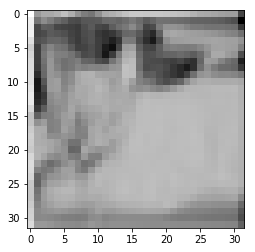

In [58]:
my_new_convolution_with_padding = L.Convolution2D(3, 1, ksize=3, pad=1)

convolved_third_image = my_new_convolution_with_padding(batch_third_image)
display_monochrome_image(convolved_third_image[0,0])

So far, we have created convolutions that output only one channels. It is just as easy to create a convolution layer that outputs 10 channels:

Dimensions of convolved_third_image: (1, 10, 32, 32)


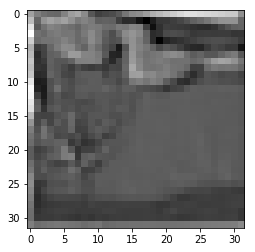

In [59]:
my_new_convolution_with_padding = L.Convolution2D(3, 10, ksize=3, pad=1)

convolved_third_image = my_new_convolution_with_padding(batch_third_image)

print ("Dimensions of convolved_third_image:", convolved_third_image.shape)

# Display the 8th channel of the output:
display_monochrome_image(convolved_third_image[0,7])

## F.max_pooling_2d

Next, we need a Max Pooling layer. We already saw in class what it does: it divide the spatial dimensions of an image by 2 (taking the maximum values of groups of 4 pixels).

In chainer, this is implemented by the function `F.max_pooling_2d`. A Max Pooling layer has no learnable parameters, which is why it is (in `chainer` terminology) a `function` and not a `link`.

In class, we only saw the case when we were applying Max Pooling over 2x2 windows. This is by far the most frequently used case. But it is actually possible to do the Max Pooling over windows of arbitrary sizes. Which is why there is a `ksize` argument to the `F.max_pooling_2d` function. In our cases, we will always set it to 2.

Like `L.Convolution2D`, `F.max_pooling_2d` is expecting a 4D input: `nb_inputs x np_channels x height x width`

In [60]:
max_pooled_third_image = F.max_pooling_2d(batch_third_image, ksize=2)

print("dimensions of max_pooled_third_image:", max_pooled_third_image.shape)

dimensions of max_pooled_third_image: (1, 3, 16, 16)


The effect of max pooling is to *downsample* the input. We can visualize the output for `third_image`:

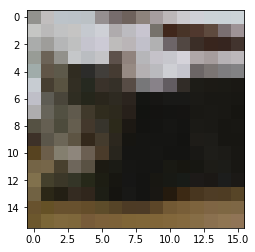

In [61]:
plt.imshow(np.moveaxis(max_pooled_third_image[0].array,0,2))

It might seem more natural to you to downsample an image by taking the average of a group of pixels (and not the maximum). It is actually possible to do that with the `F.average_pooling_2d` function.

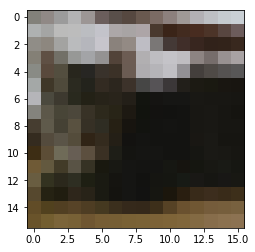

In [62]:
average_pooled_third_image = F.average_pooling_2d(batch_third_image, ksize=2)
plt.imshow(np.moveaxis(average_pooled_third_image[0].array,0,2))

while visually the transformations seems similar, it turns out the Max Pooling works better than Average Pooling in practice, which is why it is the prefered method for downsampling in Image Recognition Neural Network.

## Combining L.Convolution2D and F.max_pooling_2d

We said in class that a typical Image Recognition Neural Network will consist in a sequence of convolutional Layers and Max Pooling layers. Let us see what kind of output we get when combining both:

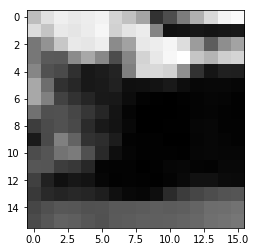

In [84]:
my_convolution = L.Convolution2D(3, 10, ksize=3, pad=1)
display_monochrome_image(F.max_pooling_2d(my_convolution(batch_third_image), ksize=2)[0,0])

## F.reshape

One additional little chainer function we will use is `F.reshape`. It simply changes the shape of an array without changing its content.

We will need it for the transition from the output of convolutional layers to the input of Fully Connected Layer. 

Indeed, as we have seen, `L.Convolution2D` and `F.max_pooling_2d` process 4D arrays of dimensions `nb_input x nb_channels x height x width`.

On the other hand, as we could see in previous notebook, `F.Linear`, which implements Fully Connected Layers in chainer, process 2D arrays of dimensions `nb_input x nb_features`.

Therefore, we will need to "flatten" the last three dimensions `nb_channels x height x width` into one dimension. This is what `F.reshape` can do for us.

In [85]:
convolved_4d_array = np.random.randn(3, 5, 8, 8).astype(np.float32)

print("Dimensions of convolved_4d_array:", convolved_4d_array.shape)

flattened_convolved_4d_array = F.reshape(convolved_4d_array, (convolved_4d_array.shape[0], -1))

print("Dimensions of flattened_convolved_4d_array:", flattened_convolved_4d_array.shape)


Dimensions of convolved_4d_array: (3, 5, 8, 8)
Dimensions of flattened_convolved_4d_array: (3, 320)


# Creating a Neural Network for Image Recognition

We know have all the building blocks for creating our Image Recognition Neural Network. Remember that our goal is to have a binary classifier that can tell us if an image represents a car or a cat.

We are going to create a small neural network with 3 convolution layers, each followed my a Max Pooling layer. At the end, we add two fully connected layers. The output of the last fully connected layer will be our class prediction: if it is close to `1`, we predict a **cat**. If it is close to `0`, we predict a **car**.

All our convolutions will have a kernel size of 3. We use padding so that the height and width of images is not changed after each convolution.

The first convolution takes inpout with 3 channels (which is necessary, as our input images have 3 channels) and produce outputs with 8 channels.

The second convolution takes input with 8 channels (which is necessary, as the output of the first convolution have 8 channels) and produce an output with 16 channels.

The last convolution takes inputs with 16 channels and produces output with 32 channels.

We could actually use any number of channels for each convolutional Layer. However, increasing the number of channels increases the number of parameters and the computation time. Also not that we usually want the number of channel to slowly increase as we go deeper in the network.

Each Max Pooling layer divide the height and width by 2. So, we starts with 32x32 images. Then we have nb_channelx16x16 arrays after the first MaxPooling Layer. Then nb_channelx8x8 arrays after the second MaxPooling Layer. Then nb_channelx4x4 arrays after the third MaxPooling Layer.

So, if we look at the dimensions of the arrays for each layers, we have (noting $n_i$ the number of input images):

[$n_i$,3,32,32]  -> 1st Conv Layer -> [$n_i$,8,32,32]

[$n_i$,8,32,32]  -> 1st MaxPooling Layer -> [$n_i$,8,16,16]

[$n_i$,8,16,16]  -> 2nd Conv Layer -> [$n_i$,16,16,16]

[$n_i$,16,16,16]  -> 2nd MaxPooling Layer -> [$n_i$,16,8,8]

[$n_i$,16,8,8]  -> 3rd Conv Layer -> [$n_i$,32,8,8]

[$n_i$,32,8,8]  -> 3rd MaxPooling Layer -> [$n_i$,32,4,4]


After this sequence of Max Pooling and Convolutional Layers, we therefore have a output that is a batch of 32x4x4 arrays.

We then add a Fully Connected layer with 512 neurons, each having 4x4x32 = 512 inputs.

Finally, we add a Fully Connected Layer with only one Neuron and 512 inputs that will produce the class prediction.


In [86]:
class CarCatRecognitionModel(chainer.Chain):
    def __init__(self):
        super().__init__()
        with self.init_scope():
            # We define the Links that are needed for the model:
            self.conv_layer_1 = L.Convolution2D(3, 8, ksize=3, pad=1)
            self.conv_layer_2 = L.Convolution2D(8, 16, ksize=3, pad=1)
            self.conv_layer_3 = L.Convolution2D(16, 32, ksize=3, pad=1)
            self.fc_layer_1 = L.Linear(4*4*32, 512)
            self.fc_layer_2 = L.Linear(512, 1)
        
    def __call__(self, images):
        scores = self.compute_scores(images)
        return F.sigmoid(scores)
    
    def compute_scores(self, images):
        # We check how many input we have in each batched input:
        minibatch_size = images.shape[0]
        
        # We apply in succession the convolutional layers and the max pooling layers
        h = self.conv_layer_1(images)
        h = F.max_pooling_2d(h, ksize=2)
        h = self.conv_layer_2(h)
        h = F.max_pooling_2d(h, ksize=2)
        h = self.conv_layer_3(h)
        h = F.max_pooling_2d(h, ksize=2)
        
        # To apply the fully connected layer, we need to "flatten" the array
        flattened_output = F.reshape(h, (minibatch_size, -1))
        
        # We apply the first fully conneted layer
        h = F.sigmoid(self.fc_layer_1(flattened_output))
        
        # We compute the classifier score with the second fully connected layer:
        h = self.fc_layer_2(h)
        return h
    
    
# We create a randomly initialized model:
carcatmodel = CarCatRecognitionModel()

# We create an optimizer that will apply gradient descent for us:
optimizer = chainer.optimizers.Adam()

optimizer.setup(carcatmodel)

# As is good practice, we will "clip" the gradient: we "cut" values that are too high to prevent unstability during training
optimizer.add_hook(chainer.optimizer.GradientClipping(1))


We can look at the predictions of our model. Because it is randomly initialized, we do not expect to have good results. Let us first look at the accuracy:

In [87]:
 evaluate_accuracy_of_model(carcatmodel, car_cat_test_set)

Accurracy is 1000/2000 = 50.0%


Now, let us visualize some predictions on the test set:

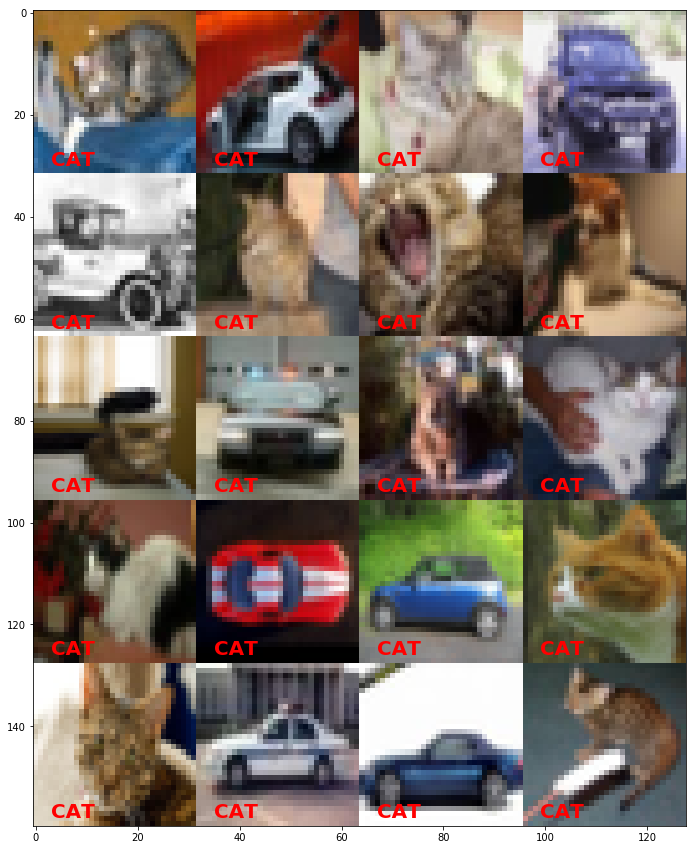

In [88]:
display_model_predictions(carcatmodel, car_cat_test_set[:20])

# Training the Neural Network

Now that we have defined our Neural Network, we want to train it with Gradient Descent.

Until now, we were using a small number of training examples (less than 100 in the previous notebook). But now we have 10 000 examples. In general when we have many examples, we do not want to process all of them at once.

We are going to take groups of 8 images from the training set, and put them in a batch array.

To that end, we define a `pack_images_in_batch` function. It will take a group of images from our training dataset and pack them in a 4D array. It will also pack the training labels in a separate array. If you have little knowledge of Python and Numpy, you can forego trying to understand its code. Just understand what it is supposed to do.


In [89]:
def pack_images_in_batch(dataset):
    batch_image = np.vstack(img[np.newaxis,...] for img, cls in dataset)
    batch_class = np.array([cls for img, cls in dataset], dtype=np.int32).reshape((-1,1))
    return batch_image, batch_class

For example, let us use this function to pack the 9th to 16th images of the training set in one batch:

In [90]:
batch_image, batch_class = pack_images_in_batch(car_cat_training_set[8:16])

print ("Dimension of batch_image:", batch_image.shape)

print ("Dimension of batch_class:", batch_class.shape)

Dimension of batch_image: (8, 3, 32, 32)
Dimension of batch_class: (8, 1)


We can now run our training loop. You can see that it works the same as in the previous notebook:

1. We initialize the gradients to zero
2. We compute model predictions.
3. We compute the loss by comparing with the real values
4. We compute the gradient by calling `backward` on the loss
5. We apply one gradient descent step by calling `optimizer.update()`

The only small difference is that we are now only processing 8 training images at the same time. (Instead of processing all of our examples at the same time in the previous notebook). This is why we have a `cursor` variable that point to the first of the next 8 training images we want to process. When we have processed all training images, we can reinitialize `cursor` to zero and go through the training data again.

Going through all of the training data once is also called "training for one epoch". We will be training for 2 epochs here, which mean we will go through our training data twice.

It is generally a good idea to randomize the order of the training images every time we start a new epoch. But we will not do that here.

In [95]:
minibatch_size = 8
number_of_epochs_to_train = 2

for num_epoch in range(number_of_epochs_to_train):
    cursor = 0
    losses = []
    while cursor < len(car_cat_training_set):
        batch_image, batch_class = pack_images_in_batch(car_cat_training_set[cursor:cursor+minibatch_size])
        cursor += minibatch_size
        
        # Set gradients to zero
        carcatmodel.cleargrads()
        
        # Compute predictions
        predictions = carcatmodel.compute_scores(batch_image)
        
        # Compute the loss
        loss = F.sigmoid_cross_entropy(predictions, batch_class)
        
        # Store the loss to compute the epoch mean loss at the end of this epoch
        losses.append(float(loss.array))
        
        # Compute the gradients with backpropagation
        loss.backward()
        
        #Apply Gradient Descent
        optimizer.update()
        
    print ("epoch", num_epoch, np.array(losses).mean())

epoch 0 0.15649537078240247
epoch 1 0.1334747423842724


After training, we can now evaluate our model again, and see that it performs much better than before training (obviously).

In [96]:
 evaluate_accuracy_of_model(carcatmodel, car_cat_test_set)

Accurracy is 1890/2000 = 94.5%


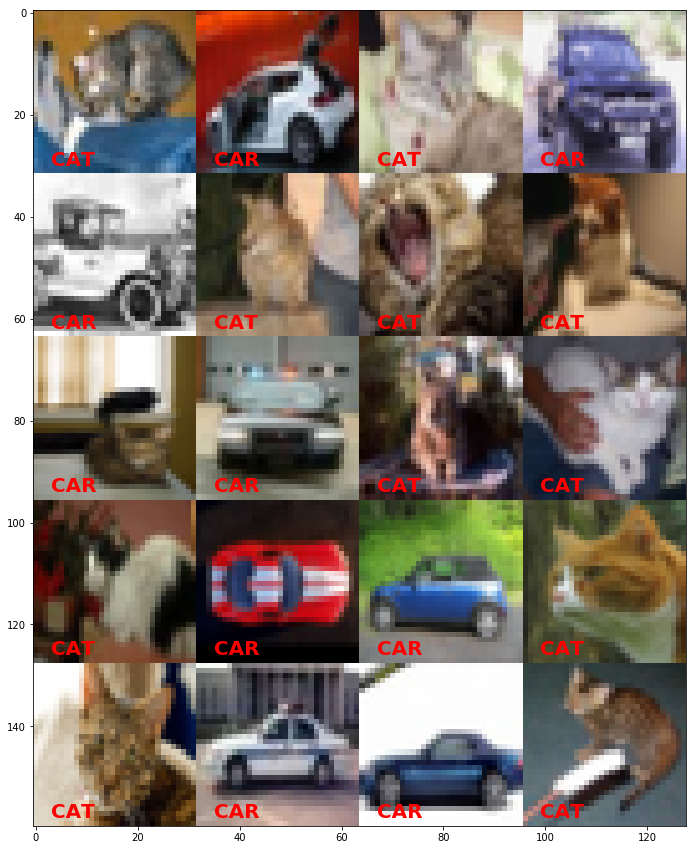

In [97]:
display_model_predictions(carcatmodel, car_cat_test_set[:20])

We can also display the beliefs of the network to see how confident it is:

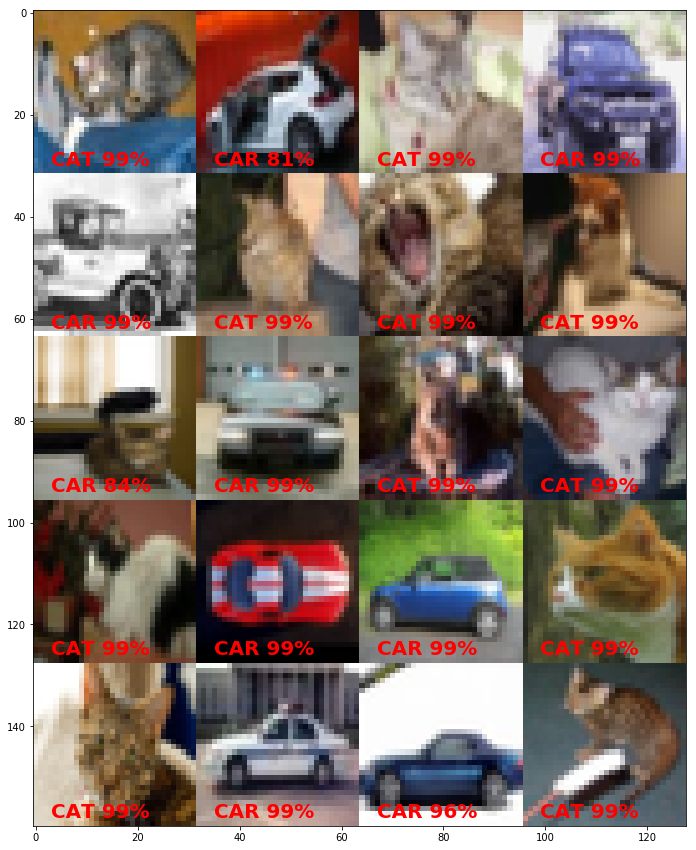

In [98]:
display_model_predictions(carcatmodel, car_cat_test_set[:20], with_beliefs=True)

# What is the Network Learning?
It is actually vey difficult to answer this question. We can at least look at how the first convolutional layer of our network is transforming our `third_image` that we extracted earlier.

We can look at a given output in the channel like this:

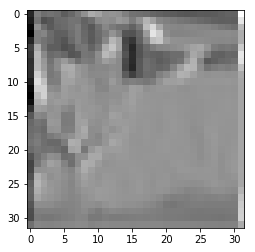

In [99]:
num_channel = 3  # num_channel should be between 0 and 7, as we have 8 output channel for the first convolution
first_convolution_output = carcatmodel.conv_layer_1(batch_third_image)
display_monochrome_image(first_convolution_output[0,num_channel])


Or we can visualize all output channels at once with the `display_all_channels` function defined above. 

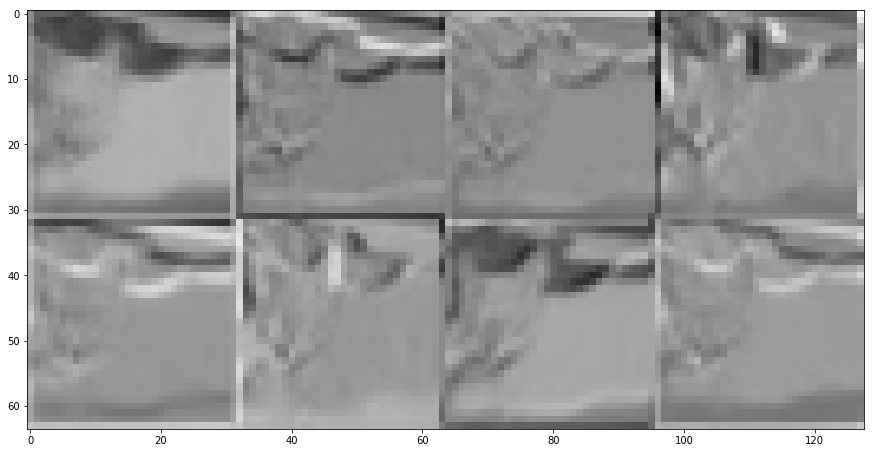

In [100]:
display_all_channels(first_convolution_output[0])

Lets do the same thing for the output of the first MaxPool Layer

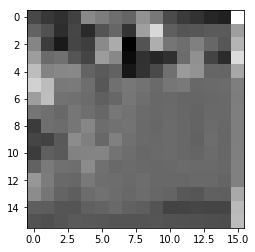

In [101]:
num_channel = 3  # num_channel should be between 0 and 7, as we have 8 output channel for the first convolution
first_maxpool_output = F.max_pooling_2d(carcatmodel.conv_layer_1(batch_third_image), ksize=2)
display_monochrome_image(first_maxpool_output[0,num_channel])

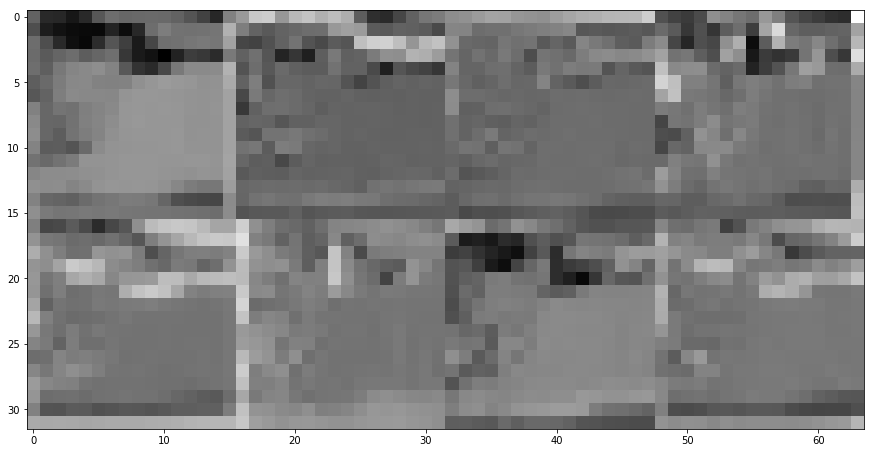

In [102]:
display_all_channels(first_maxpool_output[0])

And for the output of the second convolution layer

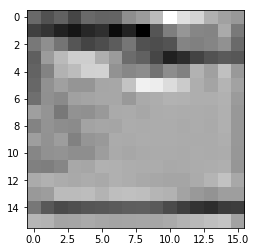

In [103]:
num_channel = 4  # num_channel should be between 0 and 15, as we have 16 output channel for the first convolution
first_maxpool_output = F.max_pooling_2d(carcatmodel.conv_layer_1(batch_third_image), ksize=2)
second_convolution_output = carcatmodel.conv_layer_2(first_maxpool_output)
display_monochrome_image(second_convolution_output[0,num_channel])



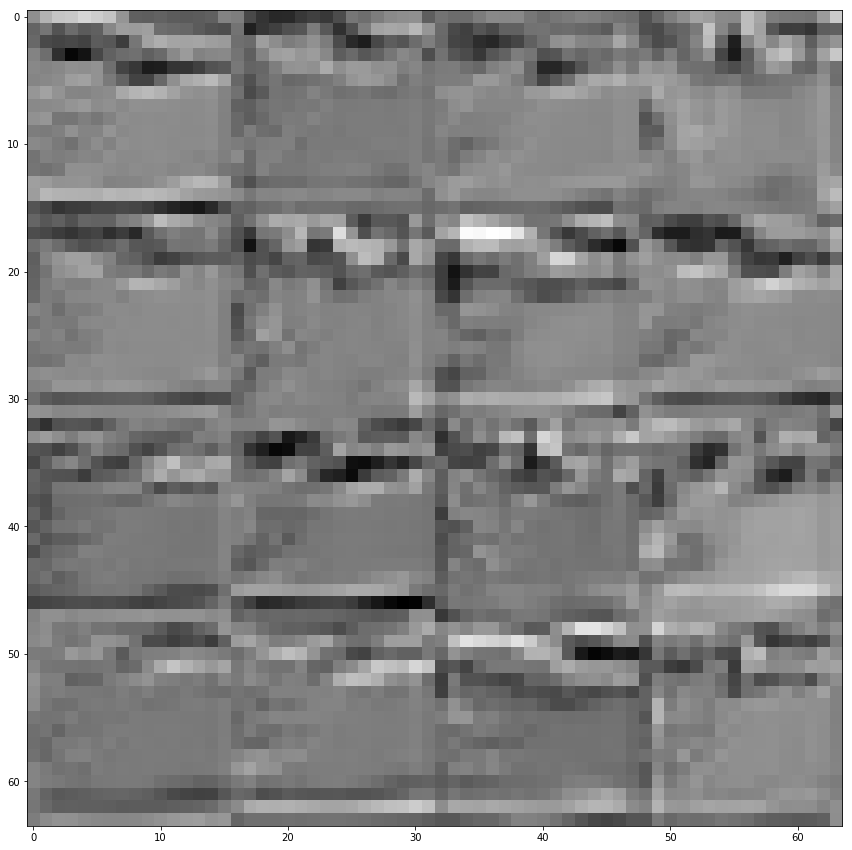

In [104]:
display_all_channels(second_convolution_output[0])

Let us check more examples:

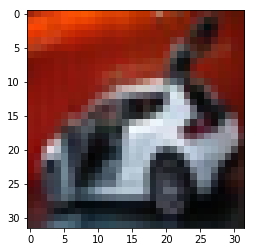

In [109]:
test_batch_image = car_cat_test_set[1][0][np.newaxis,...]
plt.imshow(np.moveaxis(test_batch_image[0], 0, 2))

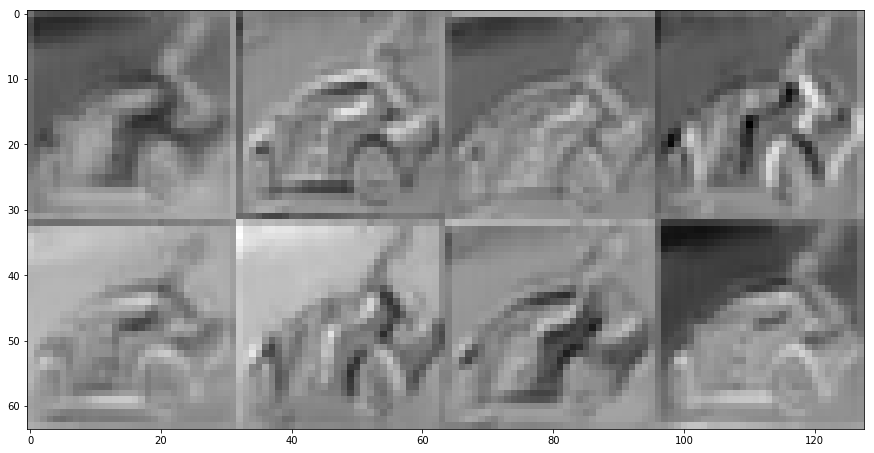

In [110]:
output_layer_1 = carcatmodel.conv_layer_1(test_batch_image)
display_all_channels(output_layer_1[0])

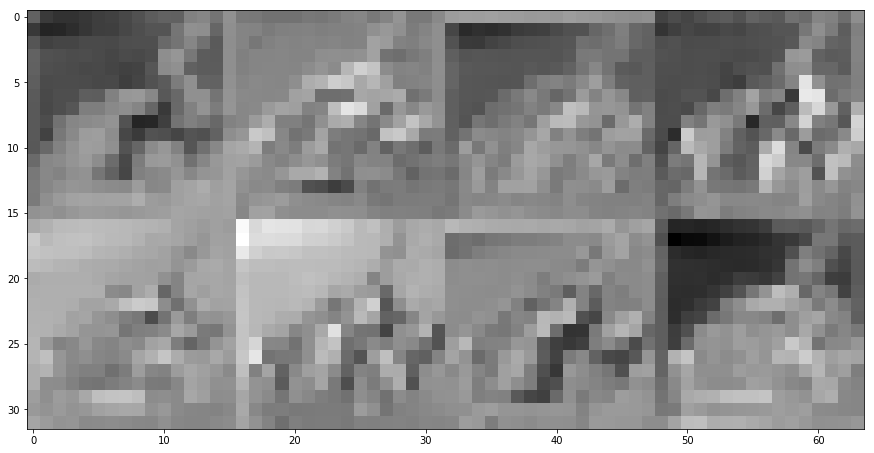

In [111]:
first_maxpool_output = F.max_pooling_2d(carcatmodel.conv_layer_1(test_batch_image), ksize=2)
display_all_channels(first_maxpool_output[0])

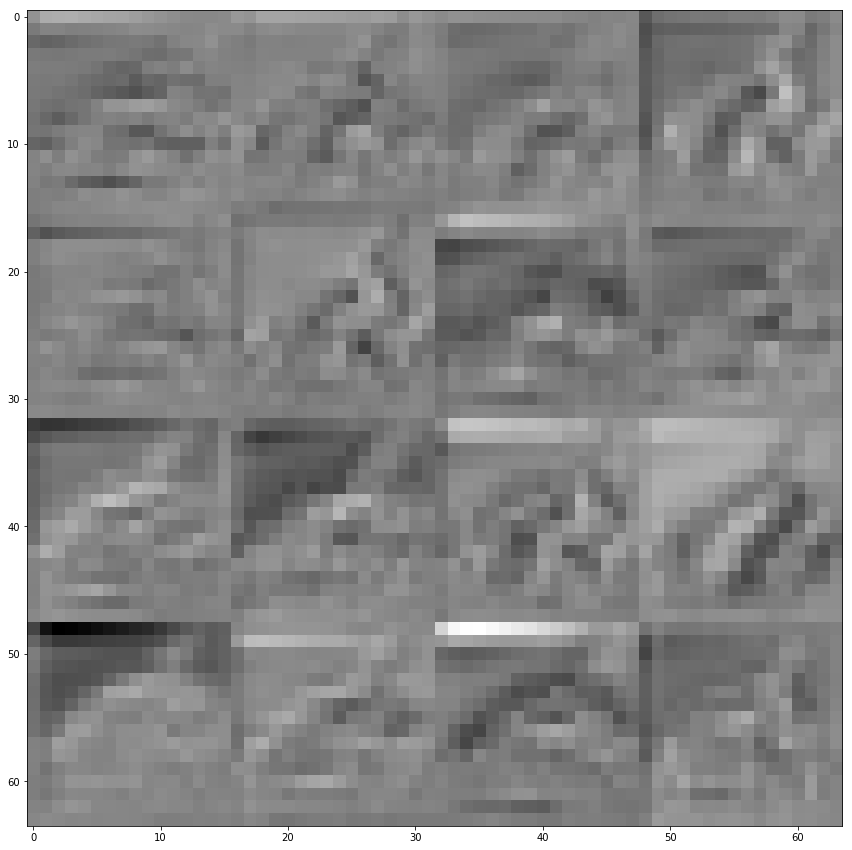

In [112]:
first_maxpool_output = F.max_pooling_2d(carcatmodel.conv_layer_1(test_batch_image), ksize=2)
second_convolution_output = carcatmodel.conv_layer_2(first_maxpool_output)
display_all_channels(second_convolution_output[0])